In [3]:
# The below code uses mapped values to get and find the predictions

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

Train Split Accuracy: 0.9341666666666667
Test Split Accuracy: 0.895
[[26 12  1  0  1  0  0  0  6  0  1  3]
 [ 2 48  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 50  0  0  0  0  0  0  0  0]
 [ 2  0  0  0 33  0 10  0  4  0  0  1]
 [ 0  0  0  0  0 50  0  0  0  0  0  0]
 [ 0  0  0  0  2  0 45  0  1  0  0  2]
 [ 0  0  0  0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  2  0  1  0 35  6  3  3]
 [ 0  0  0  0  0  0  0  0  0 50  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 50]]

Test Accuracy based on True Labels: 81.12%


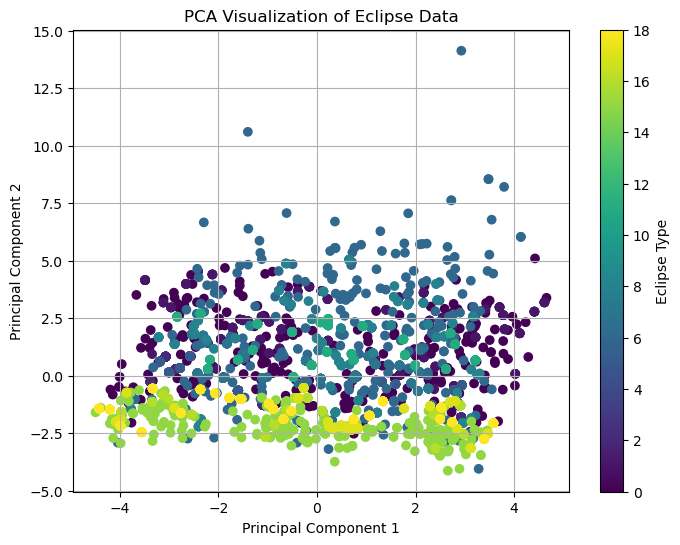

In [7]:
# Model 1 KNN - Mapped

import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import entropy
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA  # Add this import for PCA
import matplotlib.pyplot as plt

# read in the .csv file
eclipse_df = pd.read_csv("./Eclipse_Pred/Eclipse_Train.csv")

# get the numbers of the types of eclipses
total_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 0]
Tm_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 1]
Ts_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 2]
T_plus_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 3]
T_minus_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 4]
Tn_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 5]
annular_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 6]
As_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 7]
Am_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 8]
A_plus_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 9]
A_minus_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 10]
An_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 11]
partial_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 12]
Pb_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 13]
Pe_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 14]
hybrid_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 15]
Hm_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 16]
H2_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 17]
H3_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 18]

# normalize the totals for each type to reduce overfitting or other logic errors
min_count = min(len(total_eclipse), len(annular_eclipse), len(hybrid_eclipse), len(partial_eclipse), 
                len(Tm_eclipse), len(Ts_eclipse), len(T_plus_eclipse), len(T_minus_eclipse), 
                len(Tn_eclipse), len(As_eclipse), len(Am_eclipse), len(A_plus_eclipse), 
                len(A_minus_eclipse), len(An_eclipse), len(Pb_eclipse), len(Pe_eclipse), 
                len(Hm_eclipse), len(H2_eclipse), len(H3_eclipse))

if min_count < 250:
    min_count = 250
sample_total_eclipse = total_eclipse.sample(n = min_count, replace = True)
sample_Tm_eclipse = Tm_eclipse.sample(n = min_count, replace = True)
sample_Ts_eclipse = Ts_eclipse.sample(n = min_count, replace = True)
sample_T_plus_eclipse = T_plus_eclipse.sample(n = min_count, replace = True)
sample_T_minus_eclipse = T_minus_eclipse.sample(n = min_count, replace = True)
sample_Tn_eclipse = Tn_eclipse.sample(n = min_count, replace = True)
sample_annular_eclipse = annular_eclipse.sample(n = min_count, replace = True)
sample_As_eclipse = As_eclipse.sample(n = min_count, replace = True)
sample_Am_eclipse = Am_eclipse.sample(n = min_count, replace = True)
sample_A_plus_eclipse = A_plus_eclipse.sample(n = min_count, replace = True)
sample_A_minus_eclipse = A_minus_eclipse.sample(n = min_count, replace = True)
sample_An_eclipse = An_eclipse.sample(n = min_count, replace = True)
sample_partial_eclipse = partial_eclipse.sample(n = min_count, replace = True)
sample_Pb_eclipse = Pb_eclipse.sample(n = min_count, replace = True)
sample_Pe_eclipse = Pe_eclipse.sample(n = min_count, replace = True)
sample_hybrid_eclipse = hybrid_eclipse.sample(n = min_count, replace = True)
sample_Hm_eclipse = Hm_eclipse.sample(n = min_count, replace = True)
sample_H2_eclipse = H2_eclipse.sample(n = min_count, replace = True)
sample_H3_eclipse = H3_eclipse.sample(n = min_count, replace = True)

# reread the new balanced data
eclipse_df = pd.concat([sample_total_eclipse, sample_Tm_eclipse, sample_Ts_eclipse,
                        sample_T_plus_eclipse, sample_T_minus_eclipse, sample_Tn_eclipse,
                        sample_annular_eclipse, sample_As_eclipse, sample_Am_eclipse,
                        sample_A_plus_eclipse, sample_A_minus_eclipse, sample_An_eclipse,
                        sample_partial_eclipse, sample_Pb_eclipse, sample_Pe_eclipse, 
                        sample_hybrid_eclipse, sample_Hm_eclipse, sample_H2_eclipse,
                        sample_H3_eclipse], ignore_index = True)

# Drop columns with missing data in "Central Duration Seconds"
eclipse_df.dropna(subset=['Central Duration Seconds'], inplace=True)

# Replace non-numeric values in the DataFrame with NaN
eclipse_df.replace('-', np.nan, inplace=True)

# drop all features that have no or negative impact on results
eclipse_df = eclipse_df.drop(["Catalog Number", "Calendar Date", "Eclipse Time", "Latitude",
                              "Longitude", "Central Duration", "Date Time", "Visibility",
                              "Geographical Hemisphere", "Daytime/Nighttime", "Sun Constellation",
                              "Eclipse Classification", "Duration in Seconds", "Year Modulus",
                              "Decade", "ESC Moving Average", "ESC Wide-Scale Moving Average",
                              "Cluster", "Cluster 6"], axis=1)


# set the X (features) and Y (target variables)
X = eclipse_df[["Delta T (s)", "Lunation Number", "Saros Number", "Gamma",
               "Eclipse Magnitude", "Sun Altitude", "Sun Azimuth", "Path Width (km)",
               "Year", "Month", "Day", "Eclipse Latitude", "Eclipse Longitude",
               "obliquity", "Inter-Eclipse Duration", "Visibility Score",
               "Moon Distance (km)", "Sun Distance (km)", "Moon Angular Diameter (degrees)",
               "Sun Angular Diameter (degrees)", "Central Duration Seconds",
               "Normalized Duration", "Normalized Path Width", "EII", "HEAS",
               "Localized ESC", "Eclipse Interval"]]

y = eclipse_df['Eclipse Type']

# split the data between training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

# set up the pipeline for use by the param_grid
clf2 = Pipeline(steps=[('imputer', SimpleImputer(strategy="mean", missing_values = np.nan, fill_value = None)),
                       ('scaler', StandardScaler()),
                       ('knn', KNeighborsClassifier())])
# Define parameters for grid search
param_grid = {
    'knn__n_neighbors': range(3, 20),  # Test K values from 10 to 17
    'knn__metric': ['manhattan', 'chebyshev', 'minkowski'],
    'knn__weights': ['distance', 'uniform']
}

# Perform grid search, note cv is the number of folds it tests over
grid = GridSearchCV(clf2, param_grid, cv = 4, scoring='accuracy', n_jobs = -1)
grid.fit(X_train, y_train)

# Get the best parameters for KNN from grid search
best_params = grid.best_params_
best_k = best_params['knn__n_neighbors']

# Update the pipeline with the best parameters
clf2.set_params(knn__n_neighbors = best_k)

# Fit the pipeline with updated parameters
clf2.fit(X_train, y_train)

# Get the predicted labels and set up confustion matrix
y_pred = clf2.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# output all relevant accuracies
print("Train Split Accuracy:", clf2.score(X_train, y_train))
print("Test Split Accuracy:", clf2.score(X_test, y_test)) 
print(cm)

## test the data against the testing data ##

# read in the testing data
test_eclipse_df = pd.read_csv("./Eclipse_Pred/Eclipse_Test_Without_Eclipse_Type.csv", index_col = "Catalog Number")

# Drop columns with missing data in "Central Duration Seconds"
test_eclipse_df.dropna(subset=['Central Duration Seconds'], inplace=True)

# Replace non-numeric values in the DataFrame with NaN
test_eclipse_df.replace('-', np.nan, inplace=True)

# drop all features that have no or negative impact on results
test_eclipse_df = test_eclipse_df.drop(["Calendar Date", "Eclipse Time", "Latitude",
                              "Longitude", "Central Duration", "Date Time", "Visibility",
                              "Geographical Hemisphere", "Daytime/Nighttime", "Sun Constellation",
                              "Eclipse Classification", "Duration in Seconds", "Year Modulus",
                              "Decade", "ESC Moving Average", "ESC Wide-Scale Moving Average",
                              "Cluster", "Cluster 6"], axis=1)


# set the X (features) and Y (target variables)
test_X = test_eclipse_df[["Delta T (s)", "Lunation Number", "Saros Number", "Gamma",
               "Eclipse Magnitude", "Sun Altitude", "Sun Azimuth", "Path Width (km)",
               "Year", "Month", "Day", "Eclipse Latitude", "Eclipse Longitude",
               "obliquity", "Inter-Eclipse Duration", "Visibility Score",
               "Moon Distance (km)", "Sun Distance (km)", "Moon Angular Diameter (degrees)",
               "Sun Angular Diameter (degrees)", "Central Duration Seconds",
               "Normalized Duration", "Normalized Path Width", "EII", "HEAS",
               "Localized ESC", "Eclipse Interval"]]

# scale the data, then impute the data
scaler = StandardScaler()
test_X_scaled = scaler.fit_transform(test_X)
imputer = SimpleImputer(strategy='mean', missing_values=np.nan, fill_value=None)
test_X_imputed = imputer.fit_transform(test_X_scaled)

# Predict eclipse types for the testing data
y_test_pred = clf2.predict(test_X_imputed)

# Convert predicted eclipse types to integers and ensure they are within the range [0, 18]
y_test_pred = np.clip(y_test_pred, 0, 18)

# Read the true eclipse labels for the testing data
true_labels_df = pd.read_csv("./Eclipse_Pred/True_Eclipse_Test_Label.csv", index_col="Catalog Number")

# Map the predicted Eclipse types
mapped_pred = np.where((y_test_pred >= 0) & (y_test_pred <= 5), 0,  # Map 0-5 to 0
              np.where((y_test_pred >= 6) & (y_test_pred <= 11), 6,  # Map 6-11 to 6
              np.where((y_test_pred >= 12) & (y_test_pred <= 14), 12,  # Map 12-14 to 12
              np.where((y_test_pred >= 15) & (y_test_pred <= 18), 15, y_test_pred))))  # Map 15-18 to 15

# Calculate test accuracy by comparing mapped predicted and true labels
test_accuracy = np.mean(mapped_pred == true_labels_df["Eclipse Type"]) * 100
print("\nTest Accuracy based on True Labels: {:.2f}%".format(test_accuracy))

# Write the predicted eclipse types to the DataFrame
test_eclipse_df['Pred_Eclipse_Type'] = mapped_pred

# Write the predictions to a new file
test_eclipse_df.to_csv("Project3_pred.csv")

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualize the data
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.title('PCA Visualization of Eclipse Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Eclipse Type')
plt.grid(True)
plt.show()


In [3]:
# Model 2 Logistic Regression - Mapped

import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import entropy
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

# read in the .csv file
eclipse_df = pd.read_csv("./Eclipse_Pred/Eclipse_Train.csv")

# get the numbers of the types of eclipses
total_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 0]
Tm_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 1]
Ts_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 2]
T_plus_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 3]
T_minus_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 4]
Tn_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 5]
annular_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 6]
As_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 7]
Am_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 8]
A_plus_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 9]
A_minus_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 10]
An_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 11]
partial_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 12]
Pb_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 13]
Pe_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 14]
hybrid_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 15]
Hm_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 16]
H2_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 17]
H3_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 18]

# normalize the totals for each type to reduce overfitting or other logic errors
min_count = min(len(total_eclipse), len(annular_eclipse), len(hybrid_eclipse), len(partial_eclipse), 
                len(Tm_eclipse), len(Ts_eclipse), len(T_plus_eclipse), len(T_minus_eclipse), 
                len(Tn_eclipse), len(As_eclipse), len(Am_eclipse), len(A_plus_eclipse), 
                len(A_minus_eclipse), len(An_eclipse), len(Pb_eclipse), len(Pe_eclipse), 
                len(Hm_eclipse), len(H2_eclipse), len(H3_eclipse))

if min_count < 250:
    min_count = 250
sample_total_eclipse = total_eclipse.sample(n = min_count, replace = True)
sample_Tm_eclipse = Tm_eclipse.sample(n = min_count, replace = True)
sample_Ts_eclipse = Ts_eclipse.sample(n = min_count, replace = True)
sample_T_plus_eclipse = T_plus_eclipse.sample(n = min_count, replace = True)
sample_T_minus_eclipse = T_minus_eclipse.sample(n = min_count, replace = True)
sample_Tn_eclipse = Tn_eclipse.sample(n = min_count, replace = True)
sample_annular_eclipse = annular_eclipse.sample(n = min_count, replace = True)
sample_As_eclipse = As_eclipse.sample(n = min_count, replace = True)
sample_Am_eclipse = Am_eclipse.sample(n = min_count, replace = True)
sample_A_plus_eclipse = A_plus_eclipse.sample(n = min_count, replace = True)
sample_A_minus_eclipse = A_minus_eclipse.sample(n = min_count, replace = True)
sample_An_eclipse = An_eclipse.sample(n = min_count, replace = True)
sample_partial_eclipse = partial_eclipse.sample(n = min_count, replace = True)
sample_Pb_eclipse = Pb_eclipse.sample(n = min_count, replace = True)
sample_Pe_eclipse = Pe_eclipse.sample(n = min_count, replace = True)
sample_hybrid_eclipse = hybrid_eclipse.sample(n = min_count, replace = True)
sample_Hm_eclipse = Hm_eclipse.sample(n = min_count, replace = True)
sample_H2_eclipse = H2_eclipse.sample(n = min_count, replace = True)
sample_H3_eclipse = H3_eclipse.sample(n = min_count, replace = True)

# reread the new balanced data
eclipse_df = pd.concat([sample_total_eclipse, sample_Tm_eclipse, sample_Ts_eclipse,
                        sample_T_plus_eclipse, sample_T_minus_eclipse, sample_Tn_eclipse,
                        sample_annular_eclipse, sample_As_eclipse, sample_Am_eclipse,
                        sample_A_plus_eclipse, sample_A_minus_eclipse, sample_An_eclipse,
                        sample_partial_eclipse, sample_Pb_eclipse, sample_Pe_eclipse, 
                        sample_hybrid_eclipse, sample_Hm_eclipse, sample_H2_eclipse,
                        sample_H3_eclipse], ignore_index = True)

# Drop columns with missing data in "Central Duration Seconds"
eclipse_df.dropna(subset=['Central Duration Seconds'], inplace=True)

# Replace non-numeric values in the DataFrame with NaN
eclipse_df.replace('-', np.nan, inplace=True)

# drop all features that have no or negative impact on results
eclipse_df = eclipse_df.drop(["Catalog Number", "Calendar Date", "Eclipse Time", "Latitude",
                              "Longitude", "Central Duration", "Date Time", "Visibility",
                              "Geographical Hemisphere", "Daytime/Nighttime", "Sun Constellation",
                              "Eclipse Classification", "Duration in Seconds", "Year Modulus",
                              "Decade", "ESC Moving Average", "ESC Wide-Scale Moving Average",
                              "Cluster", "Cluster 6"], axis=1)


# set the X (features) and Y (target variables)
X = eclipse_df[["Delta T (s)", "Lunation Number", "Saros Number", "Gamma",
               "Eclipse Magnitude", "Sun Altitude", "Sun Azimuth", "Path Width (km)",
               "Year", "Month", "Day", "Eclipse Latitude", "Eclipse Longitude",
               "obliquity", "Inter-Eclipse Duration", "Visibility Score",
               "Moon Distance (km)", "Sun Distance (km)", "Moon Angular Diameter (degrees)",
               "Sun Angular Diameter (degrees)", "Central Duration Seconds",
               "Normalized Duration", "Normalized Path Width", "EII", "HEAS",
               "Localized ESC", "Eclipse Interval"]]

y = eclipse_df['Eclipse Type']

# split the data between training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

# set up the pipeline for use by the param_grid
clf2 = Pipeline(steps=[('imputer', SimpleImputer(strategy="mean", missing_values = np.nan, fill_value = None)),
                       ('scaler', StandardScaler()),
                       ('lr', LogisticRegression())])

# Define the parameter grid
param_grid = {
    'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'lr__penalty': ['l1', 'l2'],  # Regularization penalty
    'lr__solver': ['liblinear', 'saga'],  # Solver for optimization problem
    'lr__max_iter': [10000]  # Maximum number of iterations
}

# Initialize GridSearchCV, cv is the number of folds, verbose tells it not to state what its implementing
#and the n_jobs allows the program to utilize all of the cores of the cpu for faster times
grid = GridSearchCV(clf2, param_grid, cv=3, scoring='accuracy', verbose=0, n_jobs=-1)
grid.fit(X_train, y_train)

# Get the best parameters for logistic regression for the given data
best_params = grid.best_params_

# set the new parameters to the pipeline
clf2.set_params(**best_params)

# fit the pipeline to the data
clf2.fit(X_train, y_train)

# Get the predicted labels and set up confustion matrix
y_pred = clf2.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# output all relevant accuracies
print("Train accuracy:", clf2.score(X_train, y_train))
print("Test accuracy:", clf2.score(X_test, y_test)) 
print(cm)

## test the data against the testing data ##

# read in the testing data
test_eclipse_df = pd.read_csv("./Eclipse_Pred/Eclipse_Test_Without_Eclipse_Type.csv", index_col = "Catalog Number")

# Drop columns with missing data in "Central Duration Seconds"
test_eclipse_df.dropna(subset=['Central Duration Seconds'], inplace=True)

# Replace non-numeric values in the DataFrame with NaN
test_eclipse_df.replace('-', np.nan, inplace=True)

# drop all features that have no or negative impact on results
test_eclipse_df = test_eclipse_df.drop(["Calendar Date", "Eclipse Time", "Latitude",
                              "Longitude", "Central Duration", "Date Time", "Visibility",
                              "Geographical Hemisphere", "Daytime/Nighttime", "Sun Constellation",
                              "Eclipse Classification", "Duration in Seconds", "Year Modulus",
                              "Decade", "ESC Moving Average", "ESC Wide-Scale Moving Average",
                              "Cluster", "Cluster 6"], axis=1)


# set the X (features) and Y (target variables)
test_X = test_eclipse_df[["Delta T (s)", "Lunation Number", "Saros Number", "Gamma",
               "Eclipse Magnitude", "Sun Altitude", "Sun Azimuth", "Path Width (km)",
               "Year", "Month", "Day", "Eclipse Latitude", "Eclipse Longitude",
               "obliquity", "Inter-Eclipse Duration", "Visibility Score",
               "Moon Distance (km)", "Sun Distance (km)", "Moon Angular Diameter (degrees)",
               "Sun Angular Diameter (degrees)", "Central Duration Seconds",
               "Normalized Duration", "Normalized Path Width", "EII", "HEAS",
               "Localized ESC", "Eclipse Interval"]]

# scale the data, then impute the data
scaler = StandardScaler()
test_X_scaled = scaler.fit_transform(test_X)
imputer = SimpleImputer(strategy='mean', missing_values=np.nan, fill_value=None)
test_X_imputed = imputer.fit_transform(test_X_scaled)

# Predict eclipse types for the testing data
y_test_pred = clf2.predict(test_X_imputed)

# Convert predicted eclipse types to integers and ensure they are within the range [0, 18]
y_test_pred = np.clip(y_test_pred, 0, 18)

# Read the true eclipse labels for the testing data
true_labels_df = pd.read_csv("./Eclipse_Pred/True_Eclipse_Test_Label.csv", index_col="Catalog Number")

# Map the predicted Eclipse types
mapped_pred = np.where((y_test_pred >= 0) & (y_test_pred <= 5), 0,  # Map 0-5 to 0
              np.where((y_test_pred >= 6) & (y_test_pred <= 11), 6,  # Map 6-11 to 6
              np.where((y_test_pred >= 12) & (y_test_pred <= 14), 12,  # Map 12-14 to 12
              np.where((y_test_pred >= 15) & (y_test_pred <= 18), 15, y_test_pred))))  # Map 15-18 to 15

# Calculate test accuracy by comparing mapped predicted and true labels
test_accuracy = np.mean(mapped_pred == true_labels_df["Eclipse Type"]) * 100
print("\nTest Accuracy based on True Labels: {:.2f}%".format(test_accuracy))

# Write the predicted eclipse types to the DataFrame
test_eclipse_df['Pred_Eclipse_Type'] = mapped_pred

# Write the predictions to a new file
test_eclipse_df.to_csv("Project3_pred.csv")


Train accuracy: 0.9345833333333333
Test accuracy: 0.9216666666666666
[[42  4  0  0  0  0  0  0  0  0  2  2]
 [ 0 50  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 50  0  0  0  0  0  0  0  0]
 [ 0  1  0  0 39  0  6  1  3  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 49  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 42  4  1  3]
 [ 0  0  0  0  0  0  0  0  0 50  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 37 13]
 [ 0  0  0  0  0  0  0  0  0  0  6 44]]

Test Accuracy based on True Labels: 53.29%


In [4]:
# Model 3 Linear Regression - Mapped

import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

# read in the .csv file
eclipse_df = pd.read_csv("./Eclipse_Pred/Eclipse_Train.csv")

# get the numbers of the types of eclipses
total_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 0]
Tm_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 1]
Ts_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 2]
T_plus_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 3]
T_minus_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 4]
Tn_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 5]
annular_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 6]
As_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 7]
Am_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 8]
A_plus_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 9]
A_minus_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 10]
An_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 11]
partial_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 12]
Pb_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 13]
Pe_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 14]
hybrid_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 15]
Hm_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 16]
H2_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 17]
H3_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 18]

# normalize the totals for each type to reduce overfitting or other logic errors
min_count = min(len(total_eclipse), len(annular_eclipse), len(hybrid_eclipse), len(partial_eclipse), 
                len(Tm_eclipse), len(Ts_eclipse), len(T_plus_eclipse), len(T_minus_eclipse), 
                len(Tn_eclipse), len(As_eclipse), len(Am_eclipse), len(A_plus_eclipse), 
                len(A_minus_eclipse), len(An_eclipse), len(Pb_eclipse), len(Pe_eclipse), 
                len(Hm_eclipse), len(H2_eclipse), len(H3_eclipse))

if min_count < 250:
    min_count = 250
sample_total_eclipse = total_eclipse.sample(n = min_count, replace = True)
sample_Tm_eclipse = Tm_eclipse.sample(n = min_count, replace = True)
sample_Ts_eclipse = Ts_eclipse.sample(n = min_count, replace = True)
sample_T_plus_eclipse = T_plus_eclipse.sample(n = min_count, replace = True)
sample_T_minus_eclipse = T_minus_eclipse.sample(n = min_count, replace = True)
sample_Tn_eclipse = Tn_eclipse.sample(n = min_count, replace = True)
sample_annular_eclipse = annular_eclipse.sample(n = min_count, replace = True)
sample_As_eclipse = As_eclipse.sample(n = min_count, replace = True)
sample_Am_eclipse = Am_eclipse.sample(n = min_count, replace = True)
sample_A_plus_eclipse = A_plus_eclipse.sample(n = min_count, replace = True)
sample_A_minus_eclipse = A_minus_eclipse.sample(n = min_count, replace = True)
sample_An_eclipse = An_eclipse.sample(n = min_count, replace = True)
sample_partial_eclipse = partial_eclipse.sample(n = min_count, replace = True)
sample_Pb_eclipse = Pb_eclipse.sample(n = min_count, replace = True)
sample_Pe_eclipse = Pe_eclipse.sample(n = min_count, replace = True)
sample_hybrid_eclipse = hybrid_eclipse.sample(n = min_count, replace = True)
sample_Hm_eclipse = Hm_eclipse.sample(n = min_count, replace = True)
sample_H2_eclipse = H2_eclipse.sample(n = min_count, replace = True)
sample_H3_eclipse = H3_eclipse.sample(n = min_count, replace = True)

# reread the new balanced data
eclipse_df = pd.concat([sample_total_eclipse, sample_Tm_eclipse, sample_Ts_eclipse,
                        sample_T_plus_eclipse, sample_T_minus_eclipse, sample_Tn_eclipse,
                        sample_annular_eclipse, sample_As_eclipse, sample_Am_eclipse,
                        sample_A_plus_eclipse, sample_A_minus_eclipse, sample_An_eclipse,
                        sample_partial_eclipse, sample_Pb_eclipse, sample_Pe_eclipse, 
                        sample_hybrid_eclipse, sample_Hm_eclipse, sample_H2_eclipse,
                        sample_H3_eclipse], ignore_index = True)


# Drop rows with missing data in "Central Duration Seconds"
eclipse_df.dropna(subset=['Central Duration Seconds'], inplace=True)

# Replace non-numeric values in the DataFrame with NaN
eclipse_df.replace('-', np.nan, inplace=True)

# Drop features with no or negative impact on results
eclipse_df = eclipse_df.drop(["Catalog Number", "Calendar Date", "Eclipse Time", "Latitude",
                              "Longitude", "Central Duration", "Date Time", "Visibility",
                              "Geographical Hemisphere", "Daytime/Nighttime", "Sun Constellation",
                              "Eclipse Classification", "Duration in Seconds", "Year Modulus",
                              "Decade", "ESC Moving Average", "ESC Wide-Scale Moving Average",
                              "Cluster", "Cluster 6"], axis=1)

# Set the X (features) and Y (target variables)
X = eclipse_df[["Delta T (s)", "Lunation Number", "Saros Number", "Gamma",
               "Eclipse Magnitude", "Sun Altitude", "Sun Azimuth", "Path Width (km)",
               "Year", "Month", "Day", "Eclipse Latitude", "Eclipse Longitude",
               "obliquity", "Inter-Eclipse Duration", "Visibility Score",
               "Moon Distance (km)", "Sun Distance (km)", "Moon Angular Diameter (degrees)",
               "Sun Angular Diameter (degrees)", "Central Duration Seconds",
               "Normalized Duration", "Normalized Path Width", "EII", "HEAS",
               "Localized ESC", "Eclipse Interval"]]

y = eclipse_df['Eclipse Type']

# Split the data between training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Set up the pipeline for use by the param_grid
clf2 = Pipeline(steps=[('imputer', SimpleImputer(strategy="mean", missing_values = np.nan, fill_value = None)),
                       ('scaler', StandardScaler()),
                       ('lr', LinearRegression())])

# Define the parameter grid
param_grid = {
    'lr__fit_intercept': [True, False],  # Whether to calculate the intercept for this model
    'lr__copy_X': [True, False],  # Whether to copy the data (True) or overwrite it (False)
}

# Initialize GridSearchCV
grid_search = GridSearchCV(clf2, param_grid, cv=4, scoring='accuracy', verbose=0, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters for linear regression
best_params = grid_search.best_params_

# Set the new parameters to the pipeline
clf2.set_params(**best_params)

# Fit the pipeline to the data
clf2.fit(X_train, y_train)

# output all relevant accuracies
print("Train Split Accuracy:", clf2.score(X_train, y_train))
print("Test Split Accuracy:", clf2.score(X_test, y_test)) 

## test the data against the testing data ##

# read in the testing data
test_eclipse_df = pd.read_csv("./Eclipse_Pred/Eclipse_Test_Without_Eclipse_Type.csv", index_col = "Catalog Number")

# Drop columns with missing data in "Central Duration Seconds"
test_eclipse_df.dropna(subset=['Central Duration Seconds'], inplace=True)

# Replace non-numeric values in the DataFrame with NaN
test_eclipse_df.replace('-', np.nan, inplace=True)

# drop all features that have no or negative impact on results
test_eclipse_df = test_eclipse_df.drop(["Calendar Date", "Eclipse Time", "Latitude",
                              "Longitude", "Central Duration", "Date Time", "Visibility",
                              "Geographical Hemisphere", "Daytime/Nighttime", "Sun Constellation",
                              "Eclipse Classification", "Duration in Seconds", "Year Modulus",
                              "Decade", "ESC Moving Average", "ESC Wide-Scale Moving Average",
                              "Cluster", "Cluster 6"], axis=1)


# set the X (features) and Y (target variables)
test_X = test_eclipse_df[["Delta T (s)", "Lunation Number", "Saros Number", "Gamma",
               "Eclipse Magnitude", "Sun Altitude", "Sun Azimuth", "Path Width (km)",
               "Year", "Month", "Day", "Eclipse Latitude", "Eclipse Longitude",
               "obliquity", "Inter-Eclipse Duration", "Visibility Score",
               "Moon Distance (km)", "Sun Distance (km)", "Moon Angular Diameter (degrees)",
               "Sun Angular Diameter (degrees)", "Central Duration Seconds",
               "Normalized Duration", "Normalized Path Width", "EII", "HEAS",
               "Localized ESC", "Eclipse Interval"]]

# scale the data, then impute the data
scaler = StandardScaler()
test_X_scaled = scaler.fit_transform(test_X)
imputer = SimpleImputer(strategy='mean', missing_values=np.nan, fill_value=None)
test_X_imputed = imputer.fit_transform(test_X_scaled)

# Predict eclipse types for the testing data
y_test_pred = clf2.predict(test_X_imputed)

# Convert predicted eclipse types to integers and ensure they are within the range [0, 18]
y_test_pred = np.clip(y_test_pred, 0, 18)

# Read the true eclipse labels for the testing data
true_labels_df = pd.read_csv("./Eclipse_Pred/True_Eclipse_Test_Label.csv", index_col="Catalog Number")

# Map the predicted Eclipse types
mapped_pred = np.where((y_test_pred >= 0) & (y_test_pred <= 5), 0,  # Map 0-5 to 0
              np.where((y_test_pred >= 6) & (y_test_pred <= 11), 6,  # Map 6-11 to 6
              np.where((y_test_pred >= 12) & (y_test_pred <= 14), 12,  # Map 12-14 to 12
              np.where((y_test_pred >= 15) & (y_test_pred <= 18), 15, y_test_pred))))  # Map 15-18 to 15

# Calculate test accuracy by comparing mapped predicted and true labels
test_accuracy = np.mean(mapped_pred == true_labels_df["Eclipse Type"]) * 100
print("\nTest Accuracy based on True Labels: {:.2f}%".format(test_accuracy))

# Write the predicted eclipse types to the DataFrame
test_eclipse_df['Pred_Eclipse_Type'] = mapped_pred

# Write the predictions to a new file
test_eclipse_df.to_csv("Project3_pred.csv")



Train Split Accuracy: 0.6726931573422666
Test Split Accuracy: 0.6670723480125293

Test Accuracy based on True Labels: 13.78%


/opt/anaconda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
           ^^^^^^^^^^^^
  File "/opt/anaconda/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
           ^^^^

In [8]:
# model 4 Support Vector Machines - Mapped

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix

# read in the .csv file
eclipse_df = pd.read_csv("./Eclipse_Pred/Eclipse_Train.csv")

# get the numbers of the types of eclipses
total_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 0]
Tm_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 1]
Ts_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 2]
T_plus_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 3]
T_minus_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 4]
Tn_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 5]
annular_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 6]
As_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 7]
Am_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 8]
A_plus_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 9]
A_minus_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 10]
An_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 11]
partial_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 12]
Pb_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 13]
Pe_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 14]
hybrid_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 15]
Hm_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 16]
H2_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 17]
H3_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 18]

# normalize the totals for each type to reduce overfitting or other logic errors
min_count = min(len(total_eclipse), len(annular_eclipse), len(hybrid_eclipse), len(partial_eclipse), 
                len(Tm_eclipse), len(Ts_eclipse), len(T_plus_eclipse), len(T_minus_eclipse), 
                len(Tn_eclipse), len(As_eclipse), len(Am_eclipse), len(A_plus_eclipse), 
                len(A_minus_eclipse), len(An_eclipse), len(Pb_eclipse), len(Pe_eclipse), 
                len(Hm_eclipse), len(H2_eclipse), len(H3_eclipse))

if min_count < 250:
    min_count = 250
sample_total_eclipse = total_eclipse.sample(n = min_count, replace = True)
sample_Tm_eclipse = Tm_eclipse.sample(n = min_count, replace = True)
sample_Ts_eclipse = Ts_eclipse.sample(n = min_count, replace = True)
sample_T_plus_eclipse = T_plus_eclipse.sample(n = min_count, replace = True)
sample_T_minus_eclipse = T_minus_eclipse.sample(n = min_count, replace = True)
sample_Tn_eclipse = Tn_eclipse.sample(n = min_count, replace = True)
sample_annular_eclipse = annular_eclipse.sample(n = min_count, replace = True)
sample_As_eclipse = As_eclipse.sample(n = min_count, replace = True)
sample_Am_eclipse = Am_eclipse.sample(n = min_count, replace = True)
sample_A_plus_eclipse = A_plus_eclipse.sample(n = min_count, replace = True)
sample_A_minus_eclipse = A_minus_eclipse.sample(n = min_count, replace = True)
sample_An_eclipse = An_eclipse.sample(n = min_count, replace = True)
sample_partial_eclipse = partial_eclipse.sample(n = min_count, replace = True)
sample_Pb_eclipse = Pb_eclipse.sample(n = min_count, replace = True)
sample_Pe_eclipse = Pe_eclipse.sample(n = min_count, replace = True)
sample_hybrid_eclipse = hybrid_eclipse.sample(n = min_count, replace = True)
sample_Hm_eclipse = Hm_eclipse.sample(n = min_count, replace = True)
sample_H2_eclipse = H2_eclipse.sample(n = min_count, replace = True)
sample_H3_eclipse = H3_eclipse.sample(n = min_count, replace = True)

# reread the new balanced data
eclipse_df = pd.concat([sample_total_eclipse, sample_Tm_eclipse, sample_Ts_eclipse,
                        sample_T_plus_eclipse, sample_T_minus_eclipse, sample_Tn_eclipse,
                        sample_annular_eclipse, sample_As_eclipse, sample_Am_eclipse,
                        sample_A_plus_eclipse, sample_A_minus_eclipse, sample_An_eclipse,
                        sample_partial_eclipse, sample_Pb_eclipse, sample_Pe_eclipse, 
                        sample_hybrid_eclipse, sample_Hm_eclipse, sample_H2_eclipse,
                        sample_H3_eclipse], ignore_index = True)


# Drop rows with missing data in "Central Duration Seconds"
eclipse_df.dropna(subset=['Central Duration Seconds'], inplace=True)

# Replace non-numeric values in the DataFrame with NaN
eclipse_df.replace('-', np.nan, inplace=True)

# Drop features with no or negative impact on results
eclipse_df = eclipse_df.drop(["Catalog Number", "Calendar Date", "Eclipse Time", "Latitude",
                              "Longitude", "Central Duration", "Date Time", "Visibility",
                              "Geographical Hemisphere", "Daytime/Nighttime", "Sun Constellation",
                              "Eclipse Classification", "Duration in Seconds", "Year Modulus",
                              "Decade", "ESC Moving Average", "ESC Wide-Scale Moving Average",
                              "Cluster", "Cluster 6"], axis=1)

# Set the X (features) and Y (target variables)
X = eclipse_df[["Delta T (s)", "Lunation Number", "Saros Number", "Gamma",
               "Eclipse Magnitude", "Sun Altitude", "Sun Azimuth", "Path Width (km)",
               "Year", "Month", "Day", "Eclipse Latitude", "Eclipse Longitude",
               "obliquity", "Inter-Eclipse Duration", "Visibility Score",
               "Moon Distance (km)", "Sun Distance (km)", "Moon Angular Diameter (degrees)",
               "Sun Angular Diameter (degrees)", "Central Duration Seconds",
               "Normalized Duration", "Normalized Path Width", "EII", "HEAS",
               "Localized ESC", "Eclipse Interval"]]

y = eclipse_df['Eclipse Type']

# Split the data between training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

# Set up the pipeline for use by the param_grid
clf2 = Pipeline(steps=[('imputer', SimpleImputer(strategy="mean", missing_values = np.nan, fill_value = None)),
                       ('scaler', StandardScaler()),
                       ('svm', SVC())])

# define the parameter grid for the classifier
param_grid = {
    'svm__C': [0.01, 0.1, 1],  # Reduce C for more regularization
    'svm__kernel': ['linear'],  # Use a simpler kernel like linear
    'svm__probability': [True],  # Enable probability estimates for better calibration
    'svm__class_weight': [None, 'balanced']  # Try different class weights
}

# Create GridSearchCV
grid_search = GridSearchCV(clf2, param_grid, cv=3, scoring='accuracy', verbose=0, n_jobs=-1)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Apply best_estimator to the pipeline using set_params function
clf2.set_params(**best_estimator.get_params())

# Fit the pipeline to the training data
clf2.fit(X_train, y_train)

# Get the predicted labels and set up confustion matrix
y_pred = clf2.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Get the training and testing accuracy
train_accuracy = clf2.score(X_train, y_train)
test_accuracy = clf2.score(X_test, y_test)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print(cm)

## test the data against the testing data ##

# read in the testing data
test_eclipse_df = pd.read_csv("./Eclipse_Pred/Eclipse_Test_Without_Eclipse_Type.csv", index_col = "Catalog Number")

# Drop columns with missing data in "Central Duration Seconds"
test_eclipse_df.dropna(subset=['Central Duration Seconds'], inplace=True)

# Replace non-numeric values in the DataFrame with NaN
test_eclipse_df.replace('-', np.nan, inplace=True)

# drop all features that have no or negative impact on results
test_eclipse_df = test_eclipse_df.drop(["Calendar Date", "Eclipse Time", "Latitude",
                              "Longitude", "Central Duration", "Date Time", "Visibility",
                              "Geographical Hemisphere", "Daytime/Nighttime", "Sun Constellation",
                              "Eclipse Classification", "Duration in Seconds", "Year Modulus",
                              "Decade", "ESC Moving Average", "ESC Wide-Scale Moving Average",
                              "Cluster", "Cluster 6"], axis=1)


# set the X (features) and Y (target variables)
test_X = test_eclipse_df[["Delta T (s)", "Lunation Number", "Saros Number", "Gamma",
               "Eclipse Magnitude", "Sun Altitude", "Sun Azimuth", "Path Width (km)",
               "Year", "Month", "Day", "Eclipse Latitude", "Eclipse Longitude",
               "obliquity", "Inter-Eclipse Duration", "Visibility Score",
               "Moon Distance (km)", "Sun Distance (km)", "Moon Angular Diameter (degrees)",
               "Sun Angular Diameter (degrees)", "Central Duration Seconds",
               "Normalized Duration", "Normalized Path Width", "EII", "HEAS",
               "Localized ESC", "Eclipse Interval"]]

# scale the data, then impute the data
scaler = StandardScaler()
test_X_scaled = scaler.fit_transform(test_X)
imputer = SimpleImputer(strategy='mean', missing_values=np.nan, fill_value=None)
test_X_imputed = imputer.fit_transform(test_X_scaled)

# Predict eclipse types for the testing data
y_test_pred = clf2.predict(test_X_imputed)

# Convert predicted eclipse types to integers and ensure they are within the range [0, 18]
y_test_pred = np.clip(y_test_pred, 0, 18)

# Read the true eclipse labels for the testing data
true_labels_df = pd.read_csv("./Eclipse_Pred/True_Eclipse_Test_Label.csv", index_col="Catalog Number")

# Map the predicted Eclipse types
mapped_pred = np.where((y_test_pred >= 0) & (y_test_pred <= 5), 0,  # Map 0-5 to 0
              np.where((y_test_pred >= 6) & (y_test_pred <= 11), 6,  # Map 6-11 to 6
              np.where((y_test_pred >= 12) & (y_test_pred <= 14), 12,  # Map 12-14 to 12
              np.where((y_test_pred >= 15) & (y_test_pred <= 18), 15, y_test_pred))))  # Map 15-18 to 15

# Calculate test accuracy by comparing mapped predicted and true labels
test_accuracy = np.mean(mapped_pred == true_labels_df["Eclipse Type"]) * 100
print("\nTest Accuracy based on True Labels: {:.2f}%".format(test_accuracy))

# Write the predicted eclipse types to the DataFrame
test_eclipse_df['Pred_Eclipse_Type'] = mapped_pred

# Write the predictions to a new file
test_eclipse_df.to_csv("Project3_pred.csv")

Train Accuracy: 0.945
Test Accuracy: 0.9341666666666667
[[ 76  13   0   0   0   0   0   0   0   0   6   1]
 [  1 102   0   0   0   0   0   0   0   0   5   0]
 [  0   0  98   0   0   0   0   0   0   0   0   0]
 [  0   0   0 101   0   0   0   0   0   0   0   0]
 [  1   0   0   0  82   0  12   0   2   0   0   0]
 [  0   0   0   0   0 110   0   0   0   0   0   0]
 [  0   0   0   0   5   0  96   0   0   4   0   0]
 [  0   0   0   0   0   0   0  96   0   0   0   0]
 [  0   0   0   0   0   0   0   0  82   7   6   2]
 [  0   0   0   0   0   0   0   0   0 103   0   0]
 [  0   0   0   0   0   0   0   0   0   0  92   3]
 [  0   0   0   0   0   0   0   0   0   0  11  83]]

Test Accuracy based on True Labels: 69.76%


In [6]:
# model 5 Gradient Boosted Trees - Mapped

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix

# read in the .csv file
eclipse_df = pd.read_csv("./Eclipse_Pred/Eclipse_Train.csv")

# get the numbers of the types of eclipses
total_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 0]
Tm_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 1]
Ts_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 2]
T_plus_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 3]
T_minus_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 4]
Tn_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 5]
annular_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 6]
As_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 7]
Am_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 8]
A_plus_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 9]
A_minus_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 10]
An_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 11]
partial_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 12]
Pb_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 13]
Pe_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 14]
hybrid_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 15]
Hm_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 16]
H2_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 17]
H3_eclipse = eclipse_df[eclipse_df['Eclipse Type'] == 18]

# normalize the totals for each type to reduce overfitting or other logic errors
min_count = min(len(total_eclipse), len(annular_eclipse), len(hybrid_eclipse), len(partial_eclipse), 
                len(Tm_eclipse), len(Ts_eclipse), len(T_plus_eclipse), len(T_minus_eclipse), 
                len(Tn_eclipse), len(As_eclipse), len(Am_eclipse), len(A_plus_eclipse), 
                len(A_minus_eclipse), len(An_eclipse), len(Pb_eclipse), len(Pe_eclipse), 
                len(Hm_eclipse), len(H2_eclipse), len(H3_eclipse))

if min_count < 125:
    min_count = 125
sample_total_eclipse = total_eclipse.sample(n = min_count, replace = True)
sample_Tm_eclipse = Tm_eclipse.sample(n = min_count, replace = True)
sample_Ts_eclipse = Ts_eclipse.sample(n = min_count, replace = True)
sample_T_plus_eclipse = T_plus_eclipse.sample(n = min_count, replace = True)
sample_T_minus_eclipse = T_minus_eclipse.sample(n = min_count, replace = True)
sample_Tn_eclipse = Tn_eclipse.sample(n = min_count, replace = True)
sample_annular_eclipse = annular_eclipse.sample(n = min_count, replace = True)
sample_As_eclipse = As_eclipse.sample(n = min_count, replace = True)
sample_Am_eclipse = Am_eclipse.sample(n = min_count, replace = True)
sample_A_plus_eclipse = A_plus_eclipse.sample(n = min_count, replace = True)
sample_A_minus_eclipse = A_minus_eclipse.sample(n = min_count, replace = True)
sample_An_eclipse = An_eclipse.sample(n = min_count, replace = True)
sample_partial_eclipse = partial_eclipse.sample(n = min_count, replace = True)
sample_Pb_eclipse = Pb_eclipse.sample(n = min_count, replace = True)
sample_Pe_eclipse = Pe_eclipse.sample(n = min_count, replace = True)
sample_hybrid_eclipse = hybrid_eclipse.sample(n = min_count, replace = True)
sample_Hm_eclipse = Hm_eclipse.sample(n = min_count, replace = True)
sample_H2_eclipse = H2_eclipse.sample(n = min_count, replace = True)
sample_H3_eclipse = H3_eclipse.sample(n = min_count, replace = True)

# reread the new balanced data
eclipse_df = pd.concat([sample_total_eclipse, sample_Tm_eclipse, sample_Ts_eclipse,
                        sample_T_plus_eclipse, sample_T_minus_eclipse, sample_Tn_eclipse,
                        sample_annular_eclipse, sample_As_eclipse, sample_Am_eclipse,
                        sample_A_plus_eclipse, sample_A_minus_eclipse, sample_An_eclipse,
                        sample_partial_eclipse, sample_Pb_eclipse, sample_Pe_eclipse, 
                        sample_hybrid_eclipse, sample_Hm_eclipse, sample_H2_eclipse,
                        sample_H3_eclipse], ignore_index = True)


# Drop rows with missing data in "Central Duration Seconds"
eclipse_df.dropna(subset=['Central Duration Seconds'], inplace=True)

# Replace non-numeric values in the DataFrame with NaN
eclipse_df.replace('-', np.nan, inplace=True)

# Drop features with no or negative impact on results
eclipse_df = eclipse_df.drop(["Catalog Number", "Calendar Date", "Eclipse Time", "Latitude",
                              "Longitude", "Central Duration", "Date Time", "Visibility",
                              "Geographical Hemisphere", "Daytime/Nighttime", "Sun Constellation",
                              "Eclipse Classification", "Duration in Seconds", "Year Modulus",
                              "Decade", "ESC Moving Average", "ESC Wide-Scale Moving Average",
                              "Cluster", "Cluster 6"], axis=1)

# Set the X (features) and Y (target variables)
X = eclipse_df[["Delta T (s)", "Lunation Number", "Saros Number", "Gamma",
               "Eclipse Magnitude", "Sun Altitude", "Sun Azimuth", "Path Width (km)",
               "Year", "Month", "Day", "Eclipse Latitude", "Eclipse Longitude",
               "obliquity", "Inter-Eclipse Duration", "Visibility Score",
               "Moon Distance (km)", "Sun Distance (km)", "Moon Angular Diameter (degrees)",
               "Sun Angular Diameter (degrees)", "Central Duration Seconds",
               "Normalized Duration", "Normalized Path Width", "EII", "HEAS",
               "Localized ESC", "Eclipse Interval"]]

y = eclipse_df['Eclipse Type']

# Split the data between training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

# Set up the pipeline for use by the param_grid
clf2 = Pipeline(steps=[('imputer', SimpleImputer(strategy="mean", missing_values = np.nan, fill_value = None)),
                       ('scaler', StandardScaler()),
                       ('gradient_boosting', GradientBoostingClassifier())])

# define the parameter grid for the classifier
param_grid = {
    'gradient_boosting__max_depth': [3, 5, 7],  # Maximum depth of the individual trees
    'gradient_boosting__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'gradient_boosting__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'gradient_boosting__n_estimators': [50, 100, 200],  # Number of boosting stages to be run
    'gradient_boosting__learning_rate': [0.05, 0.1, 0.2]  # Step size shrinkage used in update to prevent overfitting
}

# Create GridSearchCV
grid_search = GridSearchCV(clf2, param_grid, cv=3, scoring='accuracy', verbose = 0, n_jobs = -1)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Apply best_estimator to the pipeline using set_params function
clf2.set_params(**best_estimator.get_params())

# Fit the pipeline to the training data
clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)

# Get the training and testing accuracy
train_accuracy = clf2.score(X_train, y_train)
test_accuracy = clf2.score(X_test, y_test)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

## test the data against the testing data ##

# read in the testing data
test_eclipse_df = pd.read_csv("./Eclipse_Pred/Eclipse_Test_Without_Eclipse_Type.csv", index_col = "Catalog Number")

# Drop columns with missing data in "Central Duration Seconds"
test_eclipse_df.dropna(subset=['Central Duration Seconds'], inplace=True)

# Replace non-numeric values in the DataFrame with NaN
test_eclipse_df.replace('-', np.nan, inplace=True)

# drop all features that have no or negative impact on results
test_eclipse_df = test_eclipse_df.drop(["Calendar Date", "Eclipse Time", "Latitude",
                              "Longitude", "Central Duration", "Date Time", "Visibility",
                              "Geographical Hemisphere", "Daytime/Nighttime", "Sun Constellation",
                              "Eclipse Classification", "Duration in Seconds", "Year Modulus",
                              "Decade", "ESC Moving Average", "ESC Wide-Scale Moving Average",
                              "Cluster", "Cluster 6"], axis=1)


# set the X (features) and Y (target variables)
test_X = test_eclipse_df[["Delta T (s)", "Lunation Number", "Saros Number", "Gamma",
               "Eclipse Magnitude", "Sun Altitude", "Sun Azimuth", "Path Width (km)",
               "Year", "Month", "Day", "Eclipse Latitude", "Eclipse Longitude",
               "obliquity", "Inter-Eclipse Duration", "Visibility Score",
               "Moon Distance (km)", "Sun Distance (km)", "Moon Angular Diameter (degrees)",
               "Sun Angular Diameter (degrees)", "Central Duration Seconds",
               "Normalized Duration", "Normalized Path Width", "EII", "HEAS",
               "Localized ESC", "Eclipse Interval"]]

# scale the data, then impute the data
scaler = StandardScaler()
test_X_scaled = scaler.fit_transform(test_X)
imputer = SimpleImputer(strategy='mean', missing_values=np.nan, fill_value=None)
test_X_imputed = imputer.fit_transform(test_X_scaled)

# Predict eclipse types for the testing data
y_test_pred = clf2.predict(test_X_imputed)

# Convert predicted eclipse types to integers and ensure they are within the range [0, 18]
y_test_pred = np.clip(y_test_pred, 0, 18)

# Read the true eclipse labels for the testing data
true_labels_df = pd.read_csv("./Eclipse_Pred/True_Eclipse_Test_Label.csv", index_col="Catalog Number")

# Map the predicted Eclipse types
mapped_pred = np.where((y_test_pred >= 0) & (y_test_pred <= 5), 0,  # Map 0-5 to 0
              np.where((y_test_pred >= 6) & (y_test_pred <= 11), 6,  # Map 6-11 to 6
              np.where((y_test_pred >= 12) & (y_test_pred <= 14), 12,  # Map 12-14 to 12
              np.where((y_test_pred >= 15) & (y_test_pred <= 18), 15, y_test_pred))))  # Map 15-18 to 15

# Calculate test accuracy by comparing mapped predicted and true labels
test_accuracy = np.mean(mapped_pred == true_labels_df["Eclipse Type"]) * 100
print("\nTest Accuracy based on True Labels: {:.2f}%".format(test_accuracy))

# Write the predicted eclipse types to the DataFrame
test_eclipse_df['Pred_Eclipse_Type'] = mapped_pred

# Write the predictions to a new file
test_eclipse_df.to_csv("Project3_pred.csv")


KeyboardInterrupt



In [ ]:
# model 6 K means - Mapped